/var/folders/6y/bvynbx6n3zv7z3lwg6vd724r0000gn/T/ipykernel_92346/1161615547.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20c")


✓ Dispatch plot saved to results/case300/scuc_dispatch.png
✓ Commitment plot saved to results/case300/scuc_commitment.png


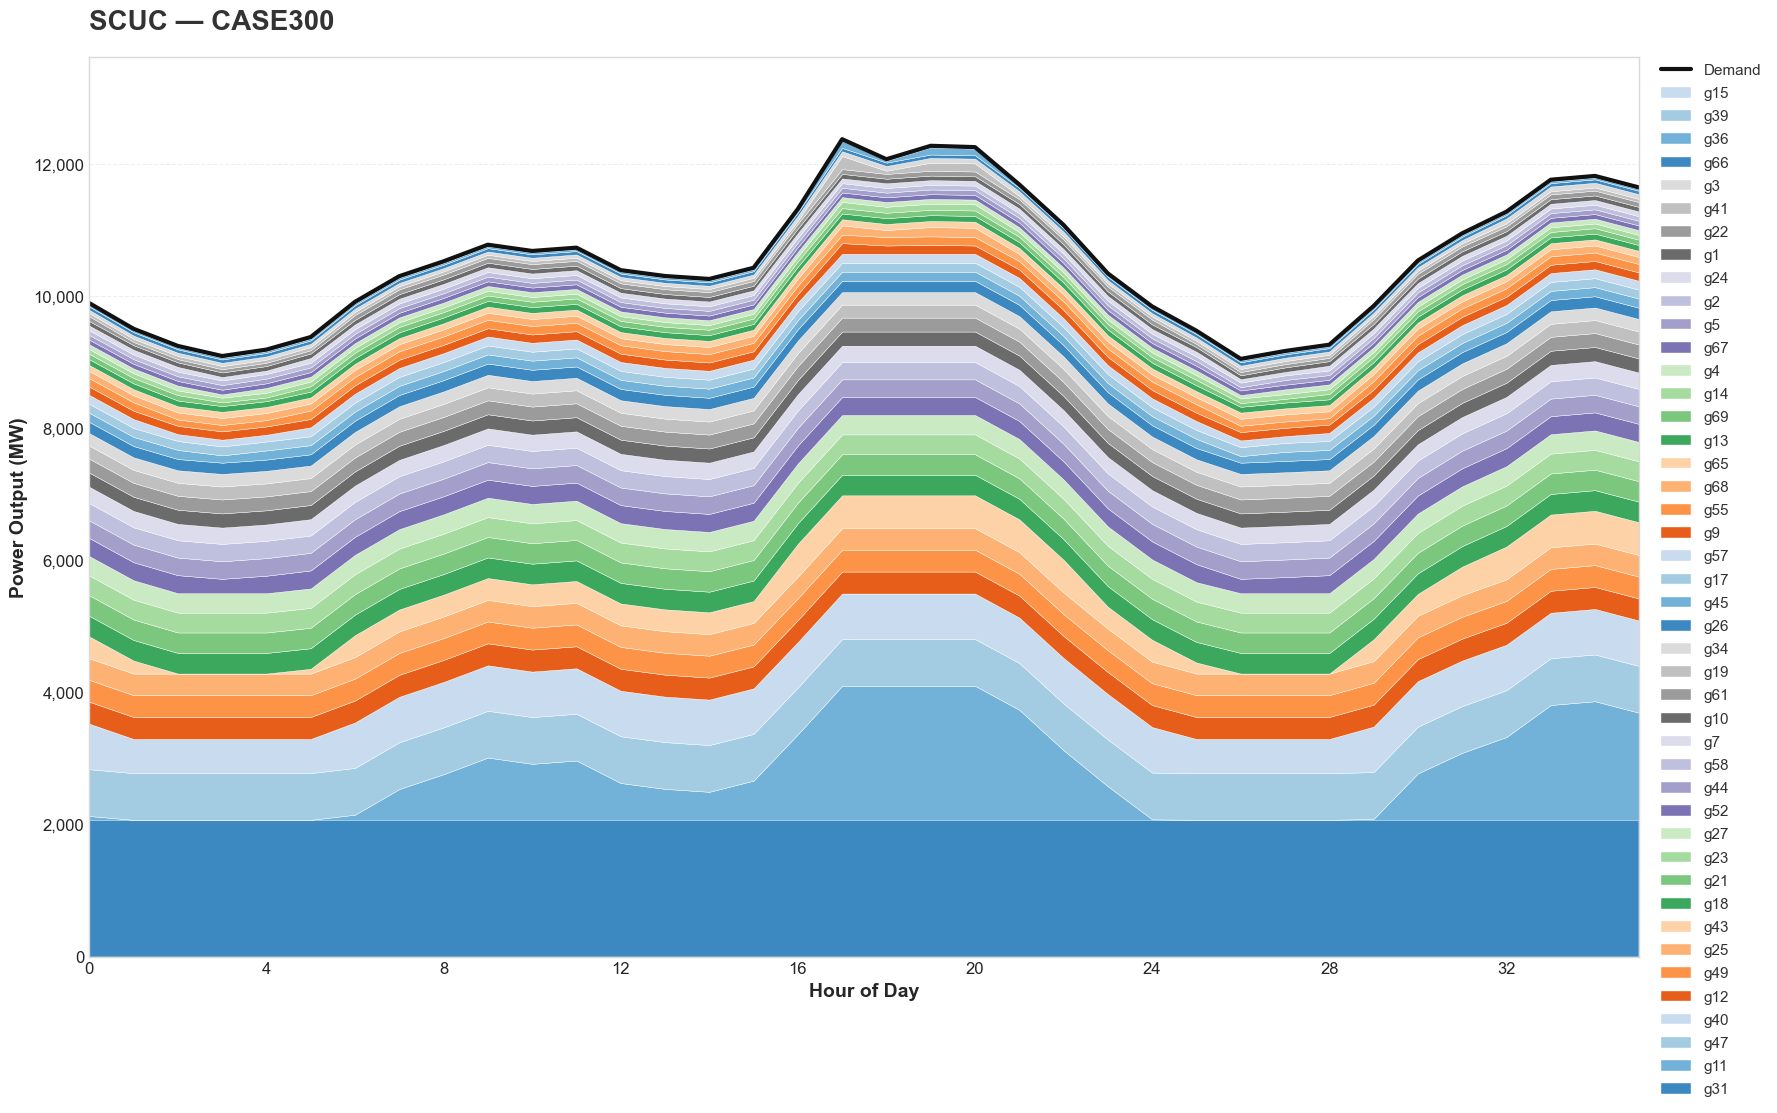

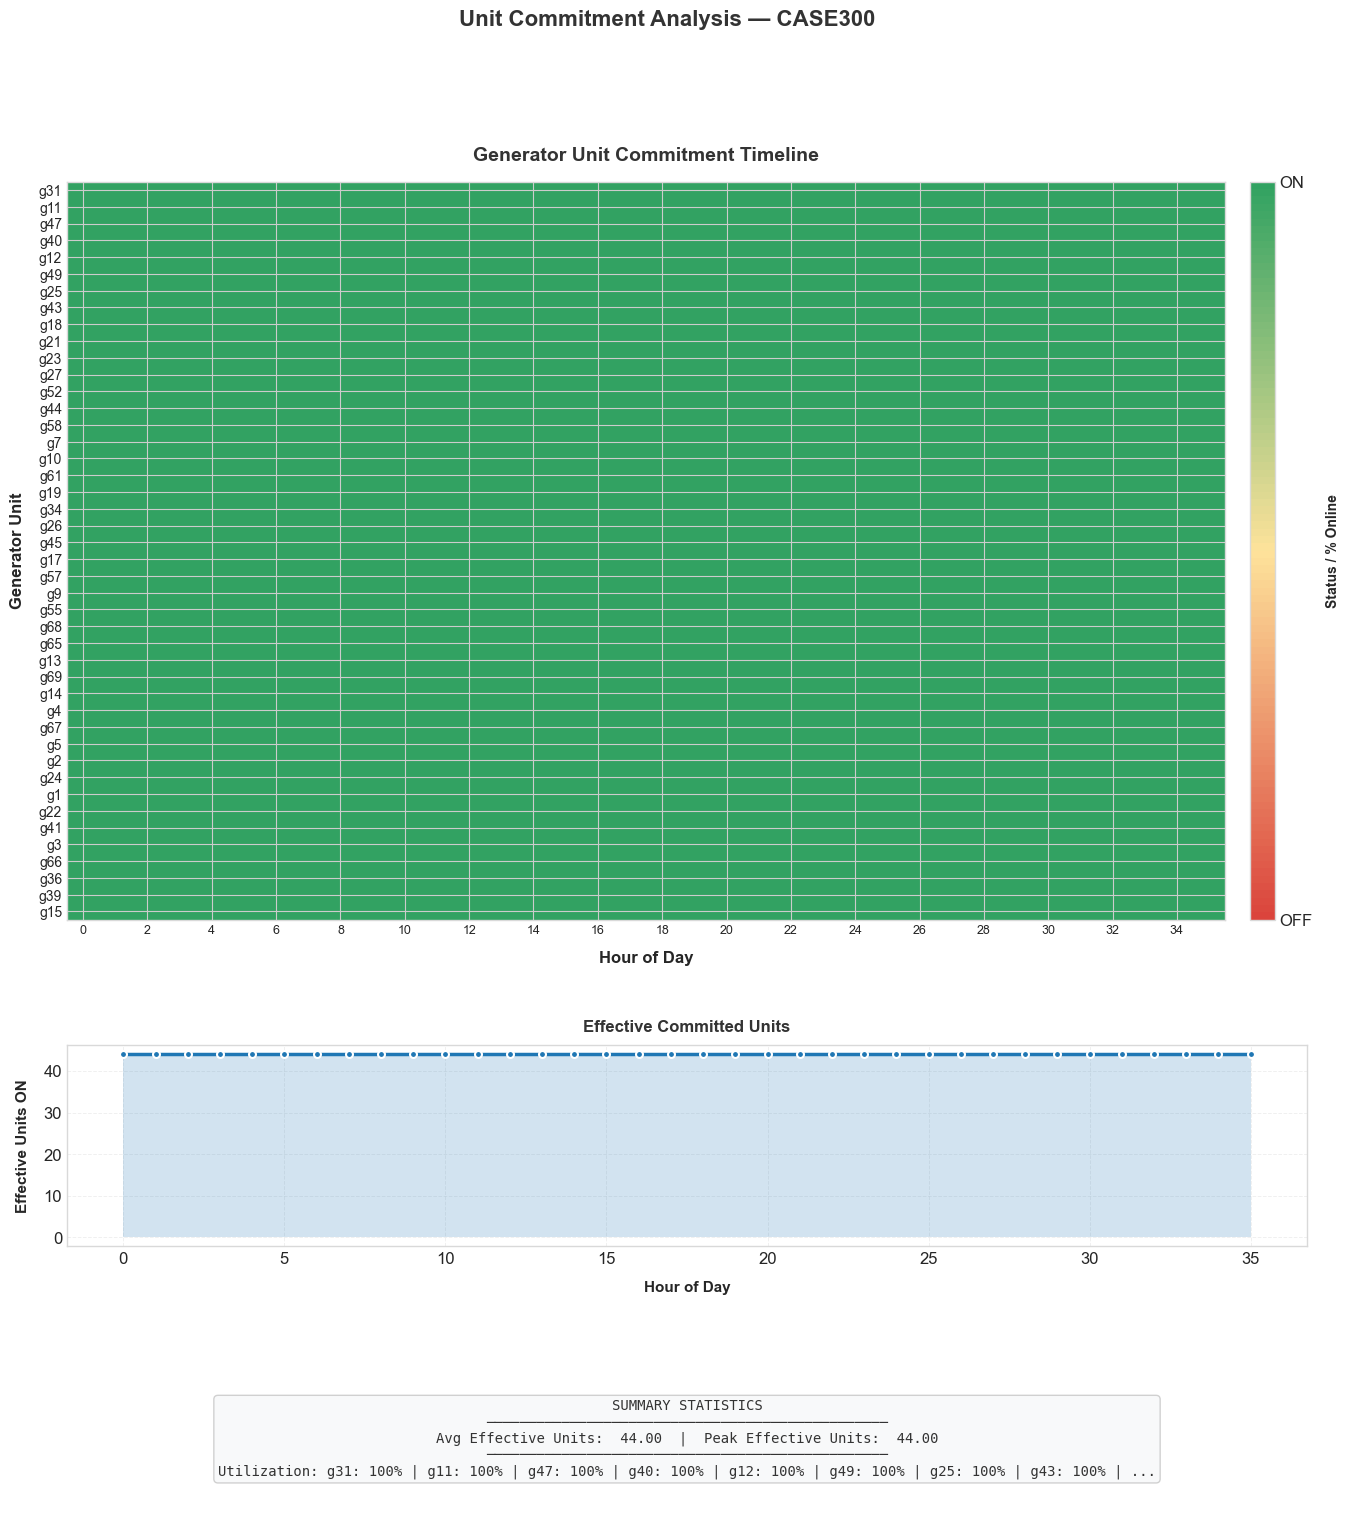

In [6]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import math


@dataclass(frozen=True)
class PlotConfig:
    base_dir: Path = Path("results") / "case300"
    csv_name: str = "dispatch.csv"
    out_dispatch: str = "scuc_dispatch.png"
    out_commit: str = "scuc_commitment.png"

    show_legend: bool = True
    top_k: int = 100
    aggregate_rest: bool = True
    min_mean_mw: float = 0.05
    commit_threshold_mw: float = 0.01

    grid_alpha: float = 0.3
    figsize_dispatch: tuple[int, int] = (20, 8) 
    figsize_commit: tuple[int, int] = (16, 12)
    demand_lw: float = 3.0

    colors: dict = None 


CFG = PlotConfig(
    colors={
        "primary": "#1f77b4",
        "demand":  "#111111",
        "other":   "#9ca3af", # Slightly darker gray for better visibility
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#d9d9d9",
    "text.color": "#333333",
    "font.size": 12,
})


def make_dummy_data(hours: int = 24, n_gens: int = 40, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    t = np.arange(hours)
    demand = 8000 + 3000 * np.sin((t - 6) * 2 * np.pi / 24) + rng.normal(0, 50, hours)

    raw_gen = np.abs(rng.normal(200, 100, (n_gens, hours)))
    raw_commit = (raw_gen > 10).astype(np.float32)

    df = pd.DataFrame({"t": t, "demand": demand})
    for i in range(n_gens):
        name = f"Gen_{i+1:02d}" # Zero padded for sorting
        df[f"p_{name}"] = raw_gen[i]
        df[f"u_{name}"] = raw_commit[i]
    return df


def load_dispatch_csv(path: Path, commit_threshold_mw: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list[str]]:
    if not path.exists():
        path.parent.mkdir(parents=True, exist_ok=True)
        print("CSV not found, generating dummy data...")
        df = make_dummy_data()
    else:
        df = pd.read_csv(path)

    if "t" not in df.columns or "demand" not in df.columns:
        raise ValueError("CSV must contain columns: 't' and 'demand'")

    gen_cols = [c for c in df.columns if c.startswith("p_")]
    if not gen_cols:
        raise ValueError("CSV must contain at least one generator column starting with 'p_'")

    gen_names = [c.replace("p_", "") for c in gen_cols]
    df = df.sort_values("t").reset_index(drop=True)

    t = df["t"].to_numpy()
    demand = df["demand"].to_numpy()
    gen = np.vstack([df[c].to_numpy() for c in gen_cols]).astype(np.float32)

    commit_cols = [f"u_{name}" for name in gen_names]
    if all(c in df.columns for c in commit_cols):
        commit = np.vstack([df[c].to_numpy() for c in commit_cols]).astype(np.float32)
    else:
        commit = (gen > commit_threshold_mw).astype(np.float32)

    return t, demand, gen, commit, gen_names


def prepare_topk(
    gen: np.ndarray,
    commit: np.ndarray,
    gen_names: list[str],
    top_k: int,
    aggregate_rest: bool,
    min_mean_mw: float
) -> tuple[np.ndarray, np.ndarray, list[str]]:
    mean_output = gen.mean(axis=1)
    keep = mean_output >= min_mean_mw

    gen = gen[keep]
    commit = commit[keep]
    names = [n for n, k in zip(gen_names, keep) if k]

    # sort by energy (descending)
    energy = gen.sum(axis=1)
    order = np.argsort(energy)[::-1]

    gen = gen[order]
    commit = commit[order]
    names = [names[i] for i in order]

    k = min(top_k, len(names))
    plot_gen = gen[:k]
    plot_commit = commit[:k]
    labels = names[:k]

    if aggregate_rest and len(names) > k:
        other_gen = gen[k:].sum(axis=0)
        other_commit = commit[k:].mean(axis=0)
        plot_gen = np.vstack([plot_gen, other_gen])
        plot_commit = np.vstack([plot_commit, other_commit])
        labels = labels + ["Other"]

    return plot_gen, plot_commit, labels


# -----------------------------
# Plot 1: Dispatch
# -----------------------------
def plot_dispatch(t: np.ndarray, demand: np.ndarray, plot_gen: np.ndarray, labels: list[str], cfg: PlotConfig) -> plt.Figure:

    base_h = cfg.figsize_dispatch[1]
    
    legend_item_height_inch = 0.22
    required_legend_h = len(labels) * legend_item_height_inch
    
    dynamic_height = max(base_h, required_legend_h + 2) # +2 for margins/title
    
    fig, ax = plt.subplots(figsize=(cfg.figsize_dispatch[0], dynamic_height), dpi=100)

    cmap = plt.cm.get_cmap("tab20c")
    colors = [cmap(i % 20) for i in range(len(labels))]
    
    if labels and labels[-1] == "Other":
        colors[-1] = cfg.colors["other"]

    polys = ax.stackplot(t, plot_gen, colors=colors, alpha=0.95, edgecolor="white", linewidth=0.3)
    
    # Demand Line
    demand_line, = ax.plot(t, demand, color=cfg.colors["demand"], linewidth=cfg.demand_lw, label="Demand")

    # Titles and Labels
    case_name = cfg.base_dir.name.upper()
    ax.set_title(f"SCUC — {case_name}", fontsize=20, fontweight="bold", pad=20, loc="left")
    ax.set_xlabel("Hour of Day", fontsize=14, fontweight="bold")
    ax.set_ylabel("Power Output (MW)", fontsize=14, fontweight="bold")

    # Grid and Axis Limits
    ax.grid(True, axis="y", linestyle="--", alpha=cfg.grid_alpha)
    ax.grid(False, axis="x")
    ax.set_xlim(t[0], t[-1])

    total_gen = np.sum(plot_gen, axis=0)
    # Ensure top margin is sufficient
    y_max = max(float(demand.max()), float(total_gen.max())) * 1.10
    ax.set_ylim(0, y_max)

    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

    # Legend Handling
    if cfg.show_legend:
        handles = [demand_line] + list(polys[::-1])
        legend_labels = ["Demand"] + labels[::-1]
        
        ax.legend(
            handles, 
            legend_labels, 
            loc="upper left", 
            bbox_to_anchor=(1.01, 1.0), 
            frameon=False,
            fontsize=11,
            labelspacing=0.6,  # More breathing room between items
            borderaxespad=0
        )

    return fig


# -----------------------------
# Plot 2: Commitment
# -----------------------------
def plot_commitment(t: np.ndarray, commit: np.ndarray, labels: list[str], cfg: PlotConfig) -> plt.Figure:
    base_h = cfg.figsize_commit[1]
    dynamic_h = max(base_h, len(labels) * 0.3 + 4)
    
    fig = plt.figure(figsize=(cfg.figsize_commit[0], dynamic_h), dpi=100)
    gs = fig.add_gridspec(3, 1, height_ratios=[max(3, len(labels)*0.1), 1.2, 0.8], hspace=0.35)

    # Heatmap
    ax_hm = fig.add_subplot(gs[0])
    cmap_custom = LinearSegmentedColormap.from_list("commitment", ["#d73027", "#fee090", "#1a9850"], N=100)

    im = ax_hm.imshow(commit, aspect="auto", cmap=cmap_custom, vmin=0, vmax=1, interpolation="nearest", alpha=0.9)

    ax_hm.set_yticks(range(len(labels)))
    ax_hm.set_yticklabels(labels, fontsize=10, fontweight="500")

    ax_hm.set_xticks(range(0, len(t), 2))
    ax_hm.set_xticklabels([str(int(i)) for i in t[::2]], fontsize=9)

    ax_hm.set_xlabel("Hour of Day", fontsize=12, fontweight="bold", labelpad=10)
    ax_hm.set_ylabel("Generator Unit", fontsize=12, fontweight="bold", labelpad=10)
    ax_hm.set_title("Generator Unit Commitment Timeline", fontsize=14, fontweight="bold", pad=15)

    cbar = plt.colorbar(im, ax=ax_hm, pad=0.02, fraction=0.046, aspect=30)
    cbar.set_label("Status / % Online", fontsize=10, fontweight="bold", labelpad=10)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["OFF", "ON"])

    # Effective committed units
    ax_total = fig.add_subplot(gs[1])
    effective_units = commit.sum(axis=0)
    max_units = len(labels)

    ax_total.fill_between(t, 0, effective_units, alpha=0.2, color=cfg.colors["primary"], edgecolor="none")
    ax_total.plot(
        t, effective_units,
        color=cfg.colors["primary"], linewidth=2.5,
        marker="o", markersize=5, markeredgecolor="white", markeredgewidth=1.5
    )

    ax_total.set_ylabel("Effective Units ON", fontsize=11, fontweight="bold", labelpad=10)
    ax_total.set_xlabel("Hour of Day", fontsize=11, fontweight="bold", labelpad=10)
    ax_total.set_title("Effective Committed Units", fontsize=12, fontweight="bold", pad=10)
    ax_total.grid(True, linestyle="--", alpha=cfg.grid_alpha, linewidth=0.7)

    # Stats
    ax_stats = fig.add_subplot(gs[2])
    ax_stats.axis("off")

    utilization = (commit.sum(axis=1) / len(t) * 100.0)
    avg_units = float(effective_units.mean())
    peak_units = float(effective_units.max())

    util_strings = [f"{g}: {u:.0f}%" for g, u in zip(labels, utilization)]
    util_text = " | ".join(util_strings[:8]) + (" | ..." if len(util_strings) > 8 else "")

    stats_text = (
        "SUMMARY STATISTICS\n"
        "────────────────────────────────────────────────\n"
        f"Avg Effective Units: {avg_units:6.2f}  |  Peak Effective Units: {peak_units:6.2f}\n"
        "────────────────────────────────────────────────\n"
        f"Utilization: {util_text}"
    )

    ax_stats.text(
        0.5, 0.5, stats_text,
        transform=ax_stats.transAxes,
        fontfamily="monospace", fontsize=10,
        va="center", ha="center",
        bbox=dict(boxstyle="round", facecolor="#f8f9fa", alpha=0.9, edgecolor="#cccccc", linewidth=1),
    )

    case_name = cfg.base_dir.name.upper()
    fig.suptitle(f"Unit Commitment Analysis — {case_name}", fontsize=16, fontweight="bold", y=0.98)
    return fig


def main(cfg: PlotConfig) -> None:
    csv_path = cfg.base_dir / cfg.csv_name
    out_dispatch = cfg.base_dir / cfg.out_dispatch
    out_commit = cfg.base_dir / cfg.out_commit

    t, demand, gen, commit, gen_names = load_dispatch_csv(csv_path, cfg.commit_threshold_mw)
    plot_gen, plot_commit, labels = prepare_topk(gen, commit, gen_names, cfg.top_k, cfg.aggregate_rest, cfg.min_mean_mw)

    # Save Dispatch
    fig1 = plot_dispatch(t, demand, plot_gen, labels, cfg)
    cfg.base_dir.mkdir(parents=True, exist_ok=True)
    fig1.savefig(out_dispatch, bbox_inches="tight", dpi=300)
    print(f"✓ Dispatch plot saved to {out_dispatch}")

    # Save Commitment
    fig2 = plot_commitment(t, plot_commit, labels, cfg)
    fig2.savefig(out_commit, bbox_inches="tight", dpi=300)
    print(f"✓ Commitment plot saved to {out_commit}")

    # plt.show() # Optional


if __name__ == "__main__":
    main(CFG)